# Heart Disease Prediction Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv("/Users/handanvural/Desktop/heart/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


In [4]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)


In [5]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

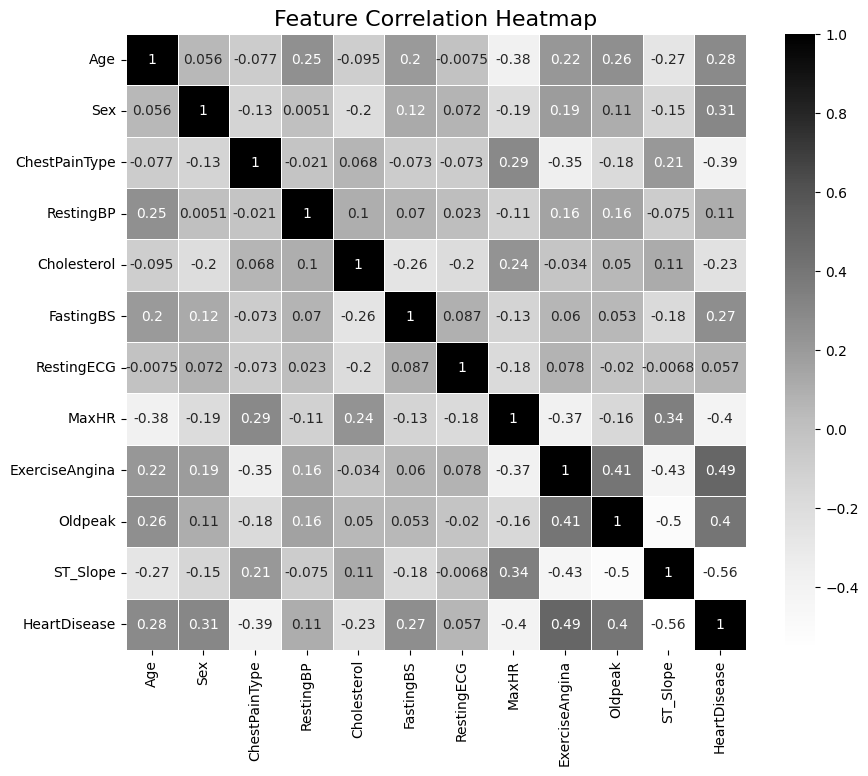

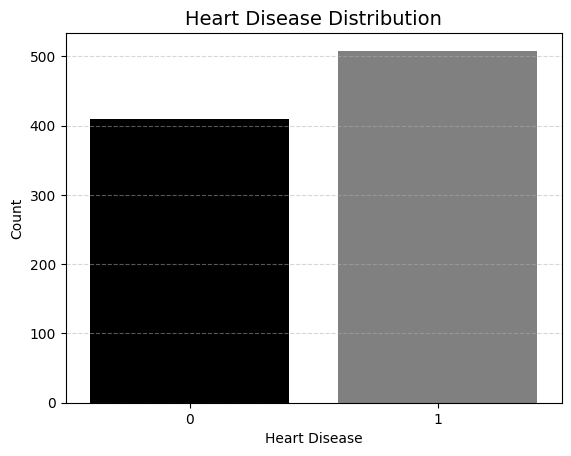

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.select_dtypes(include=[np.number]).corr(), 
    annot=True, 
    cmap="Greys",     
    linewidths=0.5, 
    linecolor='white'
)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

sns.countplot(data=df, x="HeartDisease", hue="HeartDisease", palette=["black", "gray"], legend=False)
plt.title("Heart Disease Distribution", fontsize=14)
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Normalization:

In [7]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


70% training, 15% validation, 15% testing

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

PyTorch models only accept tensor data types.
You cannot directly feed Pandas DataFrames or NumPy arrays into the model.
The DataLoader automatically splits the data into batches (small chunks) and feeds these batches to the model sequentially during training.

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)



We built a 3-layer neural network with ReLU activations and a sigmoid function in the final layer, ensuring the output stays between 0 and 1 since this is a binary classification problem.
ReLU (Rectified Linear Unit) sets negative values to zero and lets positive values pass through.
It is widely used in deep learning networks because it accelerates learning and introduces non-linearity (complex relationships).

In [10]:
class HeartNet(nn.Module):
    def __init__(self):
        super(HeartNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),  # DÜZELTİLDİ
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


optimizer.zero_grad() → Clear the gradients
model(X_batch) → Make a prediction
criterion(...) → Calculate the loss
loss.backward() → Compute gradients (backpropagation)
optimizer.step() → Update model weights

In [11]:
model = HeartNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.6384
Epoch 2/20, Loss: 0.3950
Epoch 3/20, Loss: 0.2813
Epoch 4/20, Loss: 0.1812
Epoch 5/20, Loss: 0.6643
Epoch 6/20, Loss: 0.1482
Epoch 7/20, Loss: 0.2375
Epoch 8/20, Loss: 0.1273
Epoch 9/20, Loss: 2.6500
Epoch 10/20, Loss: 0.1520
Epoch 11/20, Loss: 0.7814
Epoch 12/20, Loss: 0.2159
Epoch 13/20, Loss: 0.1016
Epoch 14/20, Loss: 0.2749
Epoch 15/20, Loss: 0.1719
Epoch 16/20, Loss: 0.0659
Epoch 17/20, Loss: 0.0733
Epoch 18/20, Loss: 0.0203
Epoch 19/20, Loss: 0.0808
Epoch 20/20, Loss: 0.7326


Hyperparameter Tuning: Learning Rate Optimization
In this study, a basic tuning was performed on the learning rate hyperparameter of the model.
The values tested were:

0.01
0.001
0.0001
For each learning rate, the model was trained from scratch and both training and validation losses were calculated.

The graph below shows how the validation loss changed for different learning rates:

With a learning rate of 0.01, the model learned quickly but the validation loss was unstable.
With 0.0001, the model learned very slowly and the validation loss decreased gradually.
With 0.001, the model learned both quickly and stably, and achieved the lowest validation loss.
The best results were obtained with learning rate = 0.001,
which allowed the model to learn accurately and in a balanced manner.
Therefore, the final model was trained using a learning rate of 0.001.


Training with learning rate: 0.01
Epoch 1/20 - Train Loss: 0.4680, Validation Loss: 0.3687
Epoch 2/20 - Train Loss: 0.3403, Validation Loss: 0.3520
Epoch 3/20 - Train Loss: 0.3215, Validation Loss: 0.2864
Epoch 4/20 - Train Loss: 0.3120, Validation Loss: 0.3152
Epoch 5/20 - Train Loss: 0.2929, Validation Loss: 0.3029
Epoch 6/20 - Train Loss: 0.2821, Validation Loss: 0.2774
Epoch 7/20 - Train Loss: 0.2824, Validation Loss: 0.2771
Epoch 8/20 - Train Loss: 0.3390, Validation Loss: 0.2675
Epoch 9/20 - Train Loss: 0.2845, Validation Loss: 0.3523
Epoch 10/20 - Train Loss: 0.3091, Validation Loss: 0.2940
Epoch 11/20 - Train Loss: 0.2412, Validation Loss: 0.2507
Epoch 12/20 - Train Loss: 0.2325, Validation Loss: 0.3242
Epoch 13/20 - Train Loss: 0.2372, Validation Loss: 0.2623
Epoch 14/20 - Train Loss: 0.2207, Validation Loss: 0.3071
Epoch 15/20 - Train Loss: 0.2040, Validation Loss: 0.2651
Epoch 16/20 - Train Loss: 0.1981, Validation Loss: 0.3393
Epoch 17/20 - Train Loss: 0.1700, Validation L

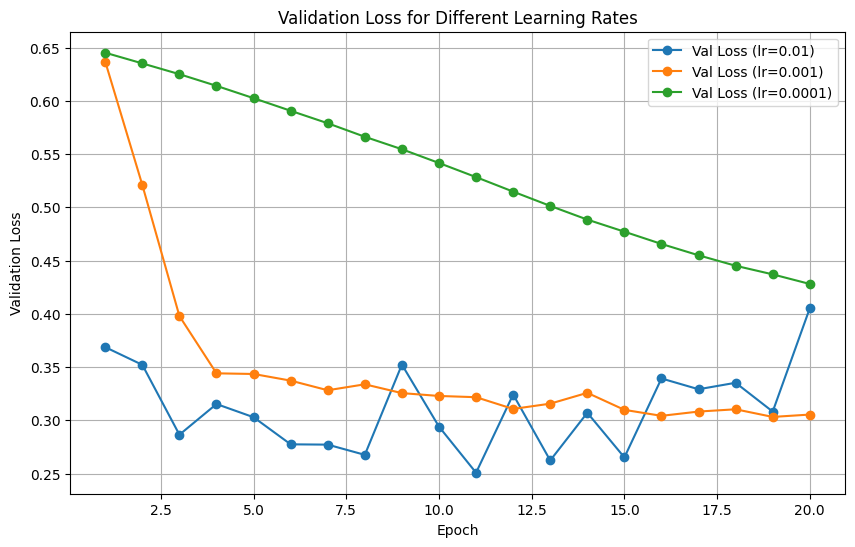

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Learning rate seçenekleri
learning_rates = [0.01, 0.001, 0.0001]

# Sonuçları kaydetmek için
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Modeli her seferinde sıfırdan başlat
    model = HeartNet()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_values = []
    val_loss_values = []
    epochs = 20

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        loss_values.append(avg_loss)

        # Validation hesapla
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_loader:
                y_pred_val = model(X_batch_val).squeeze()
                loss_val = criterion(y_pred_val, y_batch_val)
                val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Sonuçları kaydet
    results[lr] = (loss_values, val_loss_values)

# --- Hepsini aynı grafikte çiz ---
plt.figure(figsize=(10, 6))

for lr, (train_losses, val_losses) in results.items():
    plt.plot(range(1, epochs+1), val_losses, marker='o', label=f'Val Loss (lr={lr})')

plt.title("Validation Loss for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


model.eval() → Puts the model into evaluation mode
torch.no_grad() → Saves memory and enables faster inference
model(X_val_tensor) → Makes predictions on the validation data
(y_val_pred > 0.5) → Converts probabilities into class labels (0 or 1)
classification_report() → Returns performance metrics such as Precision, Recall, and F1-Score
confusion_matrix() → Displays correct and incorrect predictions in a table format

In [13]:
model.eval()
val_loss = 0

with torch.no_grad():
    for X_batch_val, y_batch_val in val_loader:
        y_pred_val = model(X_batch_val).squeeze()
        loss_val = criterion(y_pred_val, y_batch_val)
        val_loss += loss_val.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")


Validation Loss: 0.4280


torch.tensor(X_test) → Converts the test data into a PyTorch tensor
torch.no_grad() → Disables gradient computation to speed up prediction
model(X_test_tensor) → Makes predictions on the test data
(y_test_pred > 0.5) → Converts probabilities into binary class labels (0 or 1)
classification_report() → Displays the model’s performance metrics on the test set

In [14]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

with torch.no_grad():
    y_test_pred = model(X_test_tensor).squeeze()
    y_test_pred = (y_test_pred > 0.5).float()

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        55
           1       0.92      0.83      0.87        83

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138



loss_values = [] → A list to store loss values
for epoch in range(epochs) → Training loop running for 20 epochs
epoch_loss → Total loss for each epoch
optimizer.step() → Updates the model weights
loss_values.append(...) → Stores the average loss at the end of each epoch
plt.plot(...) → Plots how the loss changes over time

In [15]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

X = pd.get_dummies(X, drop_first=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

A neural network class named HeartNet is defined.
Layers are connected in sequence using nn.Sequential.
Input → 64 neurons → ReLU
64 → 32 neurons → ReLU

Since this is a binary classification problem, the final output is a value between 0 and 1, thanks to the Sigmoid activation.
When data is fed into the model, it passes through these layers and returns a result.
(This process is called the forward pass.)
model: An instance of your HeartNet neural network.
criterion: The loss function used — here it's BCELoss, because you're solving a binary classification problem.
optimizer: The algorithm that updates the model’s weights — Adam is chosen for its speed and efficiency.
You switch the model to training mode using model.train(), and initialize the total loss for each epoch to zero.

optimizer.zero_grad()               # Reset the gradients  
y_pred = model(X_batch).squeeze()   # Get predictions from the model  
loss = criterion(y_pred, y_batch)   # Calculate the loss  
loss.backward()                     # Backpropagate the loss  
optimizer.step()                    # Update the weights  
epoch_loss += loss.item()           # Add the batch loss to the total epoch loss  

Epoch 1/20, Train Loss: 0.6504, Validation Loss: 0.5852
Epoch 2/20, Train Loss: 0.5557, Validation Loss: 0.4723
Epoch 3/20, Train Loss: 0.4460, Validation Loss: 0.3814
Epoch 4/20, Train Loss: 0.3837, Validation Loss: 0.3523
Epoch 5/20, Train Loss: 0.3595, Validation Loss: 0.3353
Epoch 6/20, Train Loss: 0.3515, Validation Loss: 0.3356
Epoch 7/20, Train Loss: 0.3490, Validation Loss: 0.3302
Epoch 8/20, Train Loss: 0.3990, Validation Loss: 0.3281
Epoch 9/20, Train Loss: 0.3300, Validation Loss: 0.3267
Epoch 10/20, Train Loss: 0.3318, Validation Loss: 0.3211
Epoch 11/20, Train Loss: 0.3241, Validation Loss: 0.3161
Epoch 12/20, Train Loss: 0.3197, Validation Loss: 0.3105
Epoch 13/20, Train Loss: 0.3432, Validation Loss: 0.3069
Epoch 14/20, Train Loss: 0.3114, Validation Loss: 0.3088
Epoch 15/20, Train Loss: 0.3020, Validation Loss: 0.3112
Epoch 16/20, Train Loss: 0.3007, Validation Loss: 0.3048
Epoch 17/20, Train Loss: 0.2970, Validation Loss: 0.3011
Epoch 18/20, Train Loss: 0.2952, Validat

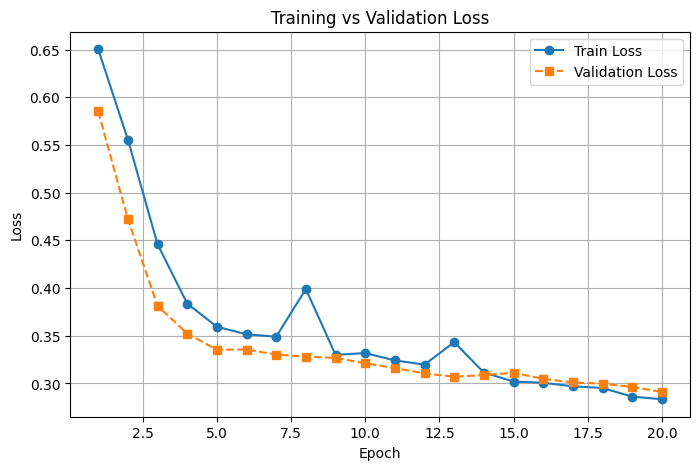

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class HeartNet(nn.Module):
    def __init__(self):
        super(HeartNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),  
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = HeartNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []
val_loss_values = []  

epochs = 20

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()             
        y_pred = model(X_batch).squeeze()  
        loss = criterion(y_pred, y_batch)  
        loss.backward()                   
        optimizer.step()                  
        epoch_loss += loss.item()          
    
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            y_pred_val = model(X_batch_val).squeeze()
            loss_val = criterion(y_pred_val, y_batch_val)
            val_loss += loss_val.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_values, marker='s', linestyle='--', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


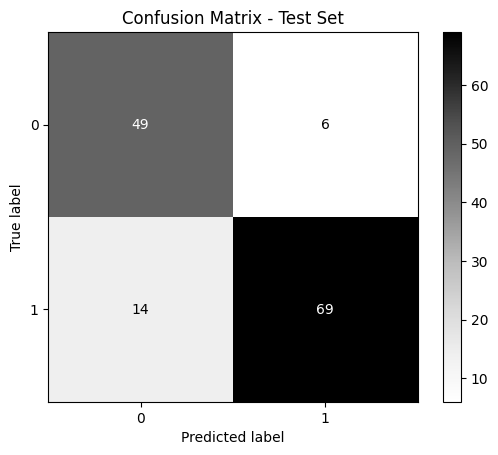

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Greys')
plt.title("Confusion Matrix - Test Set")
plt.grid(False)
plt.show()

→ This code generates the ROC curve (Receiver Operating Characteristic), which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) based on the model’s predictions on the test data.
→ The AUC (Area Under the Curve) score is calculated and displayed on the ROC curve; the closer it is to 1, the better the model distinguishes between the classes.

What is the ROC curve?
The ROC curve shows how the True Positive Rate changes with respect to the False Positive Rate at various threshold settings.
Why is it used? Because accuracy can be misleading, especially on imbalanced datasets (e.g., 95% healthy, 5% sick). A model could achieve high accuracy while failing to identify any sick patients.

What is AUC (Area Under the Curve)?
AUC measures the area under the ROC curve and provides a score between 0 and 1, representing the model's ability to distinguish between classes.

AUC = 1 → Perfect classifier
AUC = 0.5 → No discrimination (random guessing)
This way, the model’s overall performance can be easily compared using a single number.

ROC → A detailed performance visualization
AUC → A summarized performance score

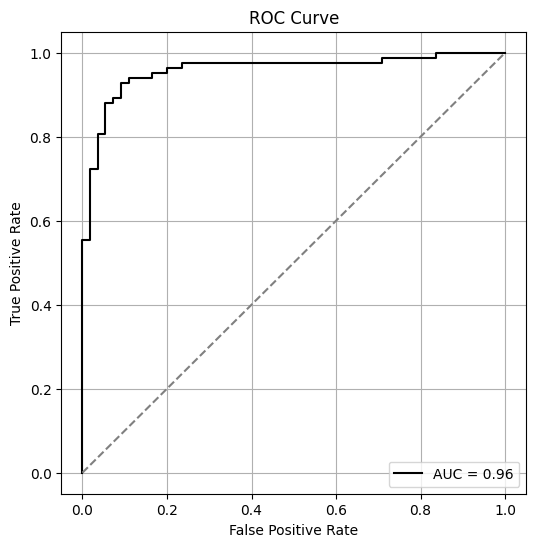

In [18]:
from sklearn.metrics import roc_curve, auc

with torch.no_grad():
    y_score = model(X_test_tensor).squeeze()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='black')
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

We save the learned weights (parameters) of the trained model.
(This is called a model checkpoint.)

In [19]:
torch.save(model.state_dict(), "heart_model.pth")

We can see both the actual results and the model’s predictions, and compare them side by side.

In [20]:
df_preds = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_test_pred.numpy()
})
df_preds.to_csv("heart_predictions.csv", index=False)